# Advanced Lane Finding

The project goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

## Camera Calibration

In camera_cal directory there are 20 camera calibration images representing a chessboard with nx=9 horizontal and ny=6 vertical intersections.
Let's read the intersections 2d points in *imgpoints* and corresponding real word 3d points in *objpoints*.

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

nx = 9
ny = 6  #  6 - most of the images
        #  5 for calibration1, calibration4 and calibration5.jpg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
    else:
        print(fname, ' :-(')  # sad face for images that don't calibrate


camera_cal\calibration1.jpg  :-(
camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration2.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration4.jpg  :-(
camera_cal\calibration5.jpg  :-(
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg


Images calibration1.jpg, calibration4.jpg and calibration5.jpg have number of intersection different  from nx=9 and ny=6, therefore these images are not going to be used for camera calibration, but we can use these images to check visually the effect of undistortion.
 <p></p> 

<figure>
 <img src="camera_cal\calibration1.jpg" width="480" alt="calibration1.jpg" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The original calibration1.jpg image </p> 
 </figcaption>
</figure>


Let's test undistortion on calibration1.jpg

calibration1.jpg img_size: (1280, 720)


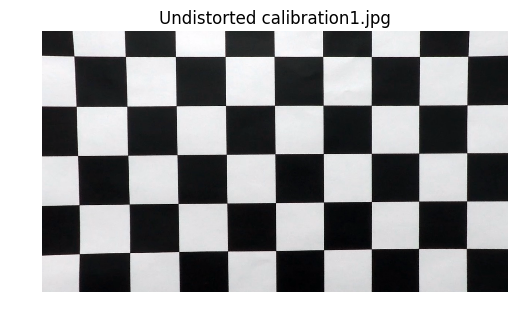

In [2]:
# Test undistortion on an image
fname = 'calibration1.jpg'
img = cv2.imread('camera_cal/' + fname)  # 1,4 and 5 were not used for calibration
img_size = (img.shape[1], img.shape[0])
print(fname, 'img_size:', img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                        objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.title('Undistorted ' + fname)
plt.axis('off')
plt.imshow(dst)


The undistorted image passed the visual test, therefore we can save the *mtx* and *dist* values for later use.

In [3]:
# Save the camera calibration result for later use 
# we won't worry about rvecs / tvecs
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/mtx_dist.pkl", "wb" ) )


## Pipeline (single images)

### Distortion Correction

Let's create an undistort function with the previously calculated parameters.

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/mtx_dist.pkl", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort(img):
    '''
    a function that takes an image, performs image distortion correction 
    with saved mtx and dist parameters and returns the undistorted image
    '''
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


Now let's take a look what happens when we undistort the images in *test_images* directory.

In [5]:
images = glob.glob('test_images/*.jpg')
images = [img for img in images if not '_ud' in img]  # keeping only unprocessed images

for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort(img)
    write_name = fname[:-4] + '_ud.jpg'
    cv2.imwrite(write_name, undist_img)

Undistorted images have been saved with suffix *\_ud*.
Comparing the first test image test1.jpg and the undistorted version test1_ud.jpg :

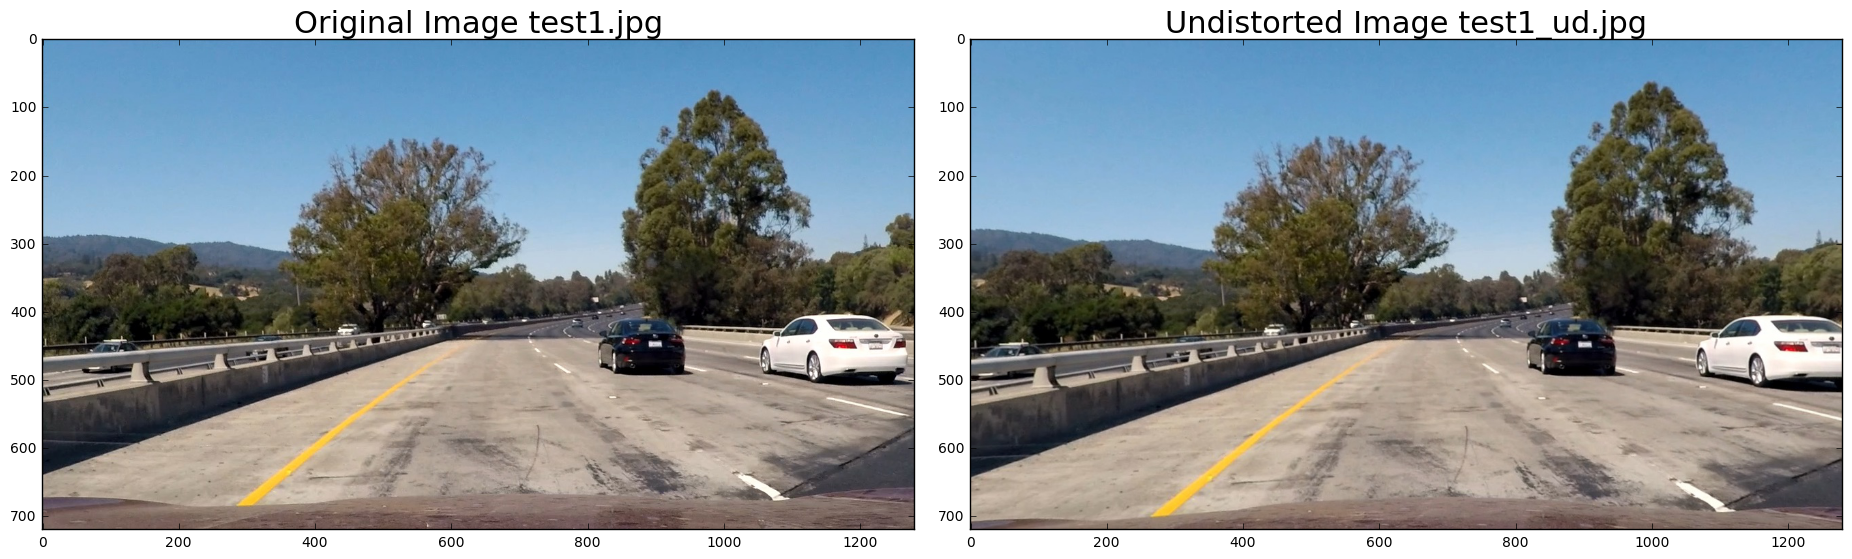

In [6]:
def show2(img1, img2, title1='Original Image', title2='Modified Image'):
    '''
    display 2 images next to each other for visual comparison
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=22)
    if img2.ndim == 2:
        ax2.imshow(img2,cmap='gray')
    else:
        ax2.imshow(img2)
    ax2.set_title(title2, fontsize=22)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()
    plt.close(f)

    
fname1 = 'test1.jpg'

img = plt.imread('test_images/' + fname1)
fname2 = fname1[:-4] + '_ud.jpg'
img_ud = plt.imread('test_images/' + fname2)

show2(img, img_ud, title1='Original Image ' + fname1, title2='Undistorted Image ' + fname2)

The visual check looks ok, we can see distortion corrections on the side of the image (e.g. the hood of our car or the white car on the right)

### Thresholded Binary Image



Create a function *tbin* which combines the tresholded x gradient of the S channel from HLS color space and a thresholded color channel and returns a binary image.

In [7]:
def tbin(img):
    '''
    input: color image (3 dimensions)
    output: thresholded binary image(2 dimensions)
    '''
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#    h_channel = hls[:,:,0]
#    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # My version of grayscale image: 0.55*red + 0.55*green - 0.1*blue
    gray = 0.55 * img[:,:,0] + 0.55 * img[:,:,1] - 0.1 * img[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    binary = np.zeros_like(s_channel)
    binary[(sxbinary==1) | (s_binary==1)] = 1
#     color_binary = 255 * np.dstack((s_binary, sxbinary, sxbinary & s_binary))
    return binary



Let's process the undistorted test images (\*_ud.jpg) with this *tbin* function and save the result with names \*_udb.jpg

In [8]:
images = glob.glob('test_images/*.jpg')
images = [img for img in images if img.endswith('_ud.jpg')]  # keeping only undistorted images

for fname in images:
    img = plt.imread(fname)
    binary = tbin(img)
    tbin_img = 255 * np.dstack((binary, binary, binary))
    write_name = fname[:-4] + 'b.jpg'  # resulting in <fname>_udb.jpg
#     show2(img,tbin_img)
    plt.imsave(write_name, tbin_img)


This is the result of the thresholded binary conversion of the undistorted image *test2_ud.jpg*

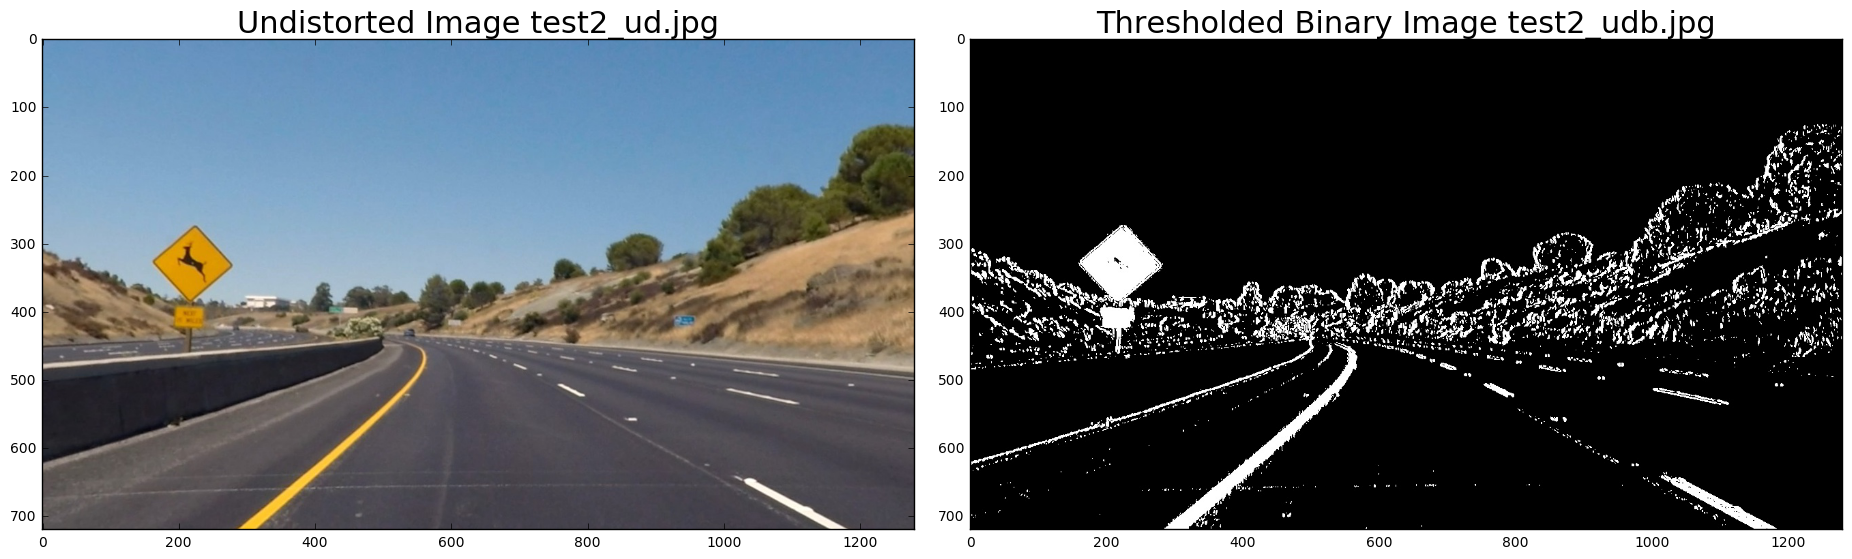

In [9]:
fname1 = 'test2_ud.jpg'

img = plt.imread('test_images/' + fname1)
fname2 = fname1[:-4] + 'b.jpg'
img_udb = plt.imread('test_images/' + fname2)

show2(img, img_udb, title1='Undistorted Image ' + fname1, title2='Thresholded Binary Image ' + fname2)

### Perspective Transform

Create *warp* function which is rectifying an image to a "birds-eye-view".

In [10]:
# Four source coordinates
a = [ 560, 460]
b = [  80, 720]
c = [1200, 720]
d = [ 720, 460]

src = np.float32([a, b, c, d])

# Four desired coordinates
A = [ 180,   0]
B = [ 180, 720]
C = [1100, 720]
D = [1100,   0]

dst = np.float32([A, B, C, D])

def warp(img, inv=False):
    # define calibration box in source (original) and
    # destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)

    # Could compute the inverse to unwarp
    if inv:
        M = cv2.getPerspectiveTransform(dst, src)  # inverse warp: dst <-> src

    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped


Check the *warp* function on a test image.

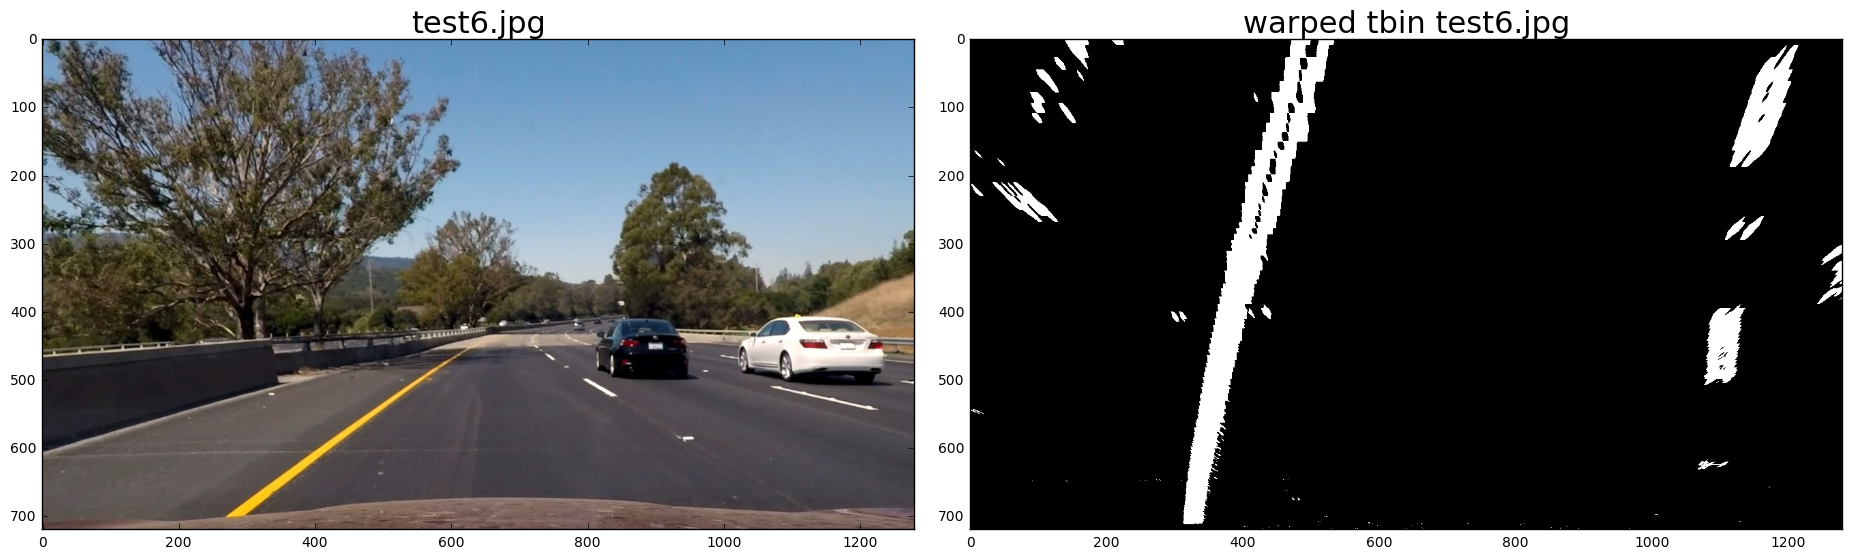

In [11]:
fname = 'test6.jpg'

img = undistort(plt.imread('test_images/' + fname))
show2(img, warp(tbin(img)), title1=fname, title2='warped tbin ' + fname)

### Identifying the Lane Boundaries

Function *lr_max* is going to identify the left and right side maximums x position of a histogram.

In [12]:

from scipy import signal
window = signal.general_gaussian(51, p=1, sig=22, sym=True)
def lr_max(histogram, y, min_height=4, min_ratio=4):
    """
    return left and right side maximum of a histogram
    """
    filtered_h = signal.fftconvolve(histogram,window,mode='same')
    avgfh = np.average(filtered_h)
    if avgfh != 0:
        filtered_h = (np.average(histogram) / avgfh) * filtered_h
    mid_x = np.int(histogram.shape[0]/2)
    left_max = np.argmax(filtered_h[0:mid_x])
    right_max = np.argmax(filtered_h[mid_x:]) + mid_x
#    f = plt.figure()
#    plt.plot(histogram)
#    plt.plot(filtered_h)
#    plt.title('y: ' + str(y) + ' lx_max: ' + str(left_max) + ' rx_max: ' + str(right_max) +
#             ' d: ' + str(right_max - left_max) + '\n lval_max: ' +
#             str(filtered_h[left_max]) + ' rval_max: ' + str(filtered_h[right_max]) +
#             '\n lmax/mean: ' + str(filtered_h[left_max] / np.mean(filtered_h[0:mid_x])) +
#             ' rmax/mean: ' + str(filtered_h[right_max] / np.mean(filtered_h[mid_x:])) )
#    plt.show()
#    plt.close(f)
    left_ratio = filtered_h[left_max] / np.mean(filtered_h[0:mid_x])
    right_ratio = filtered_h[right_max] / np.mean(filtered_h[mid_x:])
    if filtered_h[left_max] < min_height or left_ratio < min_ratio:
        left_max = None
    if filtered_h[right_max] < min_height or right_ratio < min_ratio:
        right_max = None
    return left_max, right_max


The histogram is filtered to better identify the middle of a demarcation line and there should be fullfilled the minimum height and maximum/mean ratio criterias.

The function *print_plot* is for testing purposes, it is going to plot the red dots and the fitted curve.

In [13]:

def print_plot(img, red_dots, left_fitx, right_fitx, plot_title):
    left_xs, left_ys, right_xs, right_ys = red_dots
    yvals = np.linspace(0,720, 73)
    f = plt.figure()
    plt.title(plot_title)
    plt.imshow(img, cmap='gray')
    # Plot up the data
    plt.plot(left_xs, left_ys, 'o', color='red')
    plt.plot(right_xs, right_ys, 'o', color='red')
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, yvals, color='green', linewidth=3)
    plt.plot(right_fitx, yvals, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    plt.show()
    plt.close(f)
#    diff = right_fitx - left_fitx       
#    print('fitx diff mean:', np.mean(diff))
#    print('fitx diff std:', np.std(diff))
    print('\n')


The *Line* class holds all the important parameters of the left and right lines.  

In [14]:

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, init_x):
        # age since last fit
        self.age = 22
        # blind search - in the beginning or when age > 11
        self.blind = True
        # ref dot x series
        self.xs = np.array([])
        # ref dot y series
        self.ys = np.array([])
        # polynomial coefficients for the last good fit
        self.fit = np.array([0, 0, init_x])   # initial fit
        # curverad for last good fit
        self.curverad = 0
        # yvals
        self.yvals = np.linspace(0,720, 73)
        # y_eval
        self.y_eval = 720 # np.max(left_ys)
        # fitx
        self.fitx = self.fit[0] * self.yvals**2 + self.fit[1] * self.yvals + self.fit[2]
#        self.fitx = np.array([])
    
    def dot_sanitize(self, x, y):
        '''add x,y dot coord if blind or if near to old fit
        '''
        idx = y // 10
        if self.blind or abs(x - self.fitx[idx]) < 33 + 2 * self.age:
            self.xs = np.append(self.xs, x)
            self.ys = np.append(self.ys, y)
    
    def clear_xys(self):
        self.xs = np.array([])
        self.ys = np.array([])
        
    def age_zero(self):
        self.age = 0
        self.blind = False
        
    def age_older(self):
        self.age += 1
        if self.age > 9:
            self.blind = True
            self.age = 333
            
    def fit_sanitize(self):
        if len(self.xs) > 3 and self.ys[-1] - self.ys[0] >= 240:
            cfit = np.polyfit(self.ys, self.xs, 2)  # candidate fit
            cfitx = cfit[0] * self.yvals**2 + cfit[1] * self.yvals + cfit[2]
            dir0 = np.arctan((self.fitx[1] - self.fitx[0]) / 10) / np.pi * 180
            dir1 = np.arctan((cfitx[1] - cfitx[0]) / 10) / np.pi * 180
                        
#            print('age:', self.age)
#            print('dir0: {:.0f}  dir1: {:.0f}  delta_dir: {:.0f}'.format(
#                                                                dir0, dir1, dir1-dir0))
#            print('sum cfit - fit: ', sum((cfitx - self.fitx)**2)//1000)
            if self.blind or ((sum((cfitx - self.fitx)**2) < 55555 + 3000 * self.age 
                                                   and  abs(dir1 - dir0) < 9 + self.age)):
                self.fit = cfit
                self.fitx = self.fit[0] * self.yvals**2 + self.fit[1] * self.yvals + self.fit[2]
                self.age_zero()
            else:
                self.age_older()
        else:
            self.age_older()
        
        
    def set_curverad(self, ym_per_pix, xm_per_pix):
        fit_cr = np.polyfit(self.yvals * ym_per_pix, self.fitx * xm_per_pix, 2)
        self.curverad = ((1 + (2*fit_cr[0] * self.y_eval + fit_cr[1])**2)**1.5) \
                                                           / np.absolute(2*fit_cr[0])



This class has several methods as well, the most important are the *dot_sanitize* and *fit_sanitize* which are checking the change between the old and new parameters of the line.  The *set_curverad* method is going to calculate the curvature radius.

The *paint_lane* function is going to use the previously defined functions and it will plot back the identified lane onto the original image.  

In [15]:

left_line = Line(333)
right_line = Line(1111)

def paint_lane(image, plot_title=None):
    """
    input: color image
    output: lane lines
    """
    global left_line
    global right_line

    img = warp(tbin(undistort(image)))


    left_line.clear_xys()
    right_line.clear_xys()

    img_height = int(img.shape[0])  # 720
    w_height = 60                   # window height
    step = w_height // 2  # 30

    for y in range(0, img_height - w_height + 1, step):
        histogram = np.sum(img[y : y + w_height, : ], axis=0)
        left_x, right_x = lr_max(histogram,y)
        mid_y = y + step
        if left_x and right_x:
            if right_x - left_x in range(550, 800):
                left_line.dot_sanitize(left_x, mid_y)
                right_line.dot_sanitize(right_x, mid_y)
        elif left_x:
            left_line.dot_sanitize(left_x, mid_y)
        elif right_x:
            right_line.dot_sanitize(right_x, mid_y)
                

    red_dots = (left_line.xs, left_line.ys, right_line.xs, right_line.ys)

    # Fit a second order polynomial to each lane line
    left_line.fit_sanitize()
    right_line.fit_sanitize()
    
#    if len(left_line.xs) > 3 and left_line.ys[-1] - left_line.ys[0] >= 240:
#        left_fit = np.polyfit(left_line.ys, left_line.xs, 2)
#        left_line.age_zero()
#        left_line.set_fit(left_fit)
#    else:
#        left_line.age_older()
#
#    if len(right_line.xs) > 3 and right_line.ys[-1] - right_line.ys[0] >= 240:
#        right_fit = np.polyfit(right_line.ys, right_line.xs, 2)
#        right_line.age_zero()
#        right_line.set_fit(right_fit)
#    else:
#        right_line.age_older()

    # Testing Time: plot binary image with red dots and green lane lines
    if plot_title:
        print_plot(img, red_dots, left_line.fitx, right_line.fitx, plot_title)

    # Calculate Curvature Radius
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720    # meters per pixel in y dimension
    xm_per_pix = 3.7 / (right_line.fitx[-1] - left_line.fitx[-1]) # meteres per pixel in x dimension

    if left_line.age == 0:
        left_line.set_curverad(ym_per_pix, xm_per_pix)

    if right_line.age == 0:
        right_line.set_curverad(ym_per_pix, xm_per_pix)

    # Drawing the Lines Back Down onto the Road   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.fitx, left_line.yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.fitx, right_line.yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    inv_warp = warp(color_warp, inv=True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistort(image), 1, inv_warp, 0.3, 0)
    # write curve radius on image
    curverad = (left_line.curverad * right_line.curverad) ** 0.5  
    cv2.putText(result, 'Radius of Curvature: {:.0f} m'.format(curverad), 
                                        (50, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, 255,3)
    # write distance to center on image
    dist_center = ( (right_line.fitx[-1] + left_line.fitx[-1]) / 2 - 640 ) * xm_per_pix
    cv2.putText(result, 'Distance to Center: {:.2f} m'.format(dist_center), 
                                       (50, 125), cv2.FONT_HERSHEY_SIMPLEX, 2, 255,3)
        

    return result


When it is called with the second parameter *plot_title* then it will display the warped binary image with the red dots and the fitted green line.

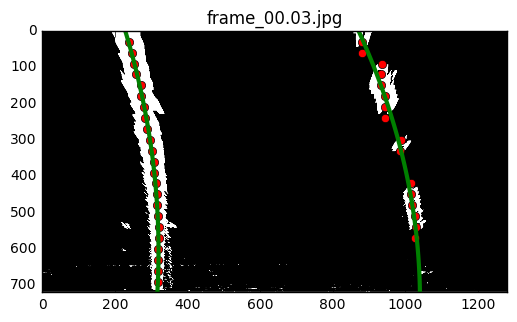

In [16]:
fname = 'frame_00.03.jpg'   # 24, 41
img = plt.imread('output_images/' + fname)
result = paint_lane(img, plot_title=fname)


There is a 60 pixel high sliding window which is stepped down by 30 pixels.  The theoretical maximum is 22 red dots which can be used for polyfit, but this can be achieved only on good quality image and continuous line.  This is the identified lane plotted back to the original image:

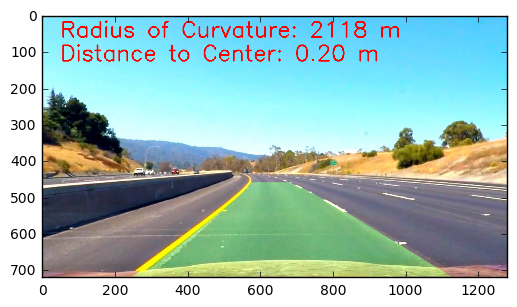

In [17]:
plt.imshow(result)

Here is another example with a somewhat confuse image:


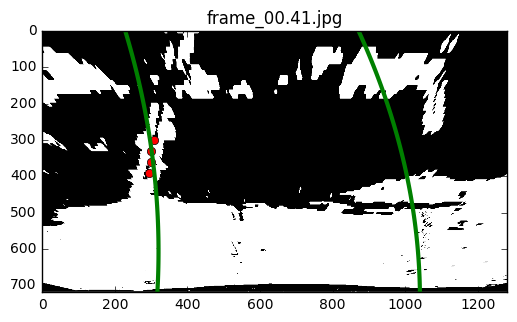

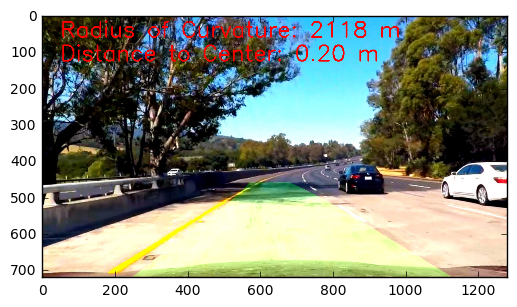

In [18]:
fname = 'frame_00.41.jpg'   # 24, 41
img = plt.imread('output_images/' + fname)
result = paint_lane(img, plot_title=fname)
plt.imshow(result)

We could see here the we keep the old curvature for lane painting because it was a very sudden change of lane lines.  The maximum of the histograms are too far from the old fit therefore these are not considered.  After a certain number of missed fitting we go back to blind search mode.  We are going to set this manually:

In [19]:
left_line.blind = True
right_line.blind = True

Now let's give one more try with the same image:

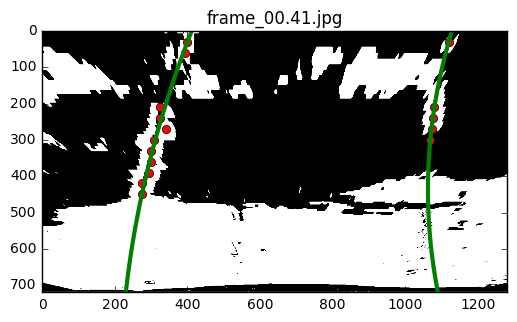

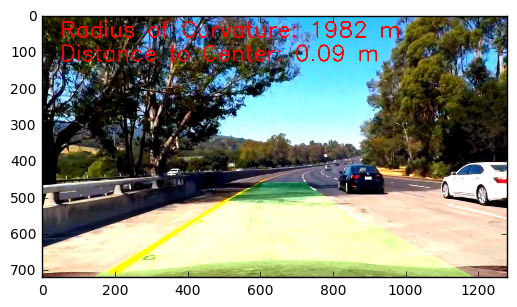

In [20]:
result = paint_lane(img, plot_title=fname)
plt.imshow(result)

output = 'project_video_result.mp4'
clip = VideoFileClip("project_video.mp4")
result_clip = clip.fl_image(paint_lane) #NOTE: this function expects color images!!
result_clip.write_videofile(output, audio=False)


In [23]:
from moviepy.editor import VideoFileClip

output = 'project_video_result.mp4'
clip = VideoFileClip("project_video.mp4")
result_clip = clip.fl_image(paint_lane) #NOTE: this function expects color images!!
result_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:20<00:00,  6.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



## Discussion

### Challenges During Project

The most diffucult during project is tracing.  While watching the result video it can be clearly seen the problem areas, but it very hard to trace the variable values exactly at that moment.  My best approach was to save snapshot images from the problematic area in the video and then I tried to recreate the environment on static images.  I am sure there are better ways to do this, hopefully I will arrive there shortly without crashing my car :-)

### Improvement Possibilities

One improvement would be to check the binary image mean value greater than 0.5 means we have too many white pixels so we can't use that image. We could try to check it in another color space it might get more relevant information about lane lines.

Another improvement could be to compare the two lane lines during sanity check or we could keep a longer history of the lane lines.